<a href="https://colab.research.google.com/github/JNicastri1/projetoML/blob/main/projeto_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de Machine Learning
Equipe: Abraão Guimarães, João Nicastri, Raphael Muniz, Kaio Zaniboni, Felipe Brum

# Base de Dados: Fraud Detection Transactions Dataset
A Fraud Detection Transactions Dataset é uma base sintética de alta qualidade voltada para experimentos de detecção de fraudes em transações financeiras. Ela foi disponibilizada no Kaggle para apoiar a construção e comparação de modelos de machine learning, em cenários com classes altamente desbalanceadas.

Link: https://www.kaggle.com/datasets/samayashar/fraud-detection-transactions-dataset/data

# Atributos da Base
* Transaction_ID:	Identificador único de cada transação
* User_ID:	Identificador único do usuário responsável pela transação
* Transaction_Amount:	Valor monetário da transação
* Transaction_Type:	Tipo de transação (por exemplo, PAYMENT, TRANSFER, CASH_OUT, etc.)
* Timestamp:	Carimbo de data e hora em que a transação ocorreu
* Account_Balance:	Saldo da conta do usuário no momento da transação
* Device_Type:	Tipo de dispositivo utilizado para executar a transação (desktop, mobile, tablet etc.)
* Location:	Localização geográfica ou região onde a transação foi iniciada
* Merchant_Category:	Categoria do comerciante ou estabelecimento onde a transação foi processada
* IP_Address_Flag:	Indicador binário (0/1) sinalizando se o IP de origem é suspeito
* Previous_Fraudulent_Activity:	Indicador (0/1) de histórico prévio de atividades fraudulentas pelo mesmo usuário
* Daily_Transaction_Count:	Quantidade de transações já realizadas pelo usuário no mesmo dia
* Avg_Transaction_Amount_7d:	Valor médio das transações do usuário nos últimos 7 dias
* Failed_Transaction_Count_7d:	Número de tentativas de transação sem sucesso nos últimos 7 dias
* Card_Type:	Tipo de cartão utilizado (crédito, débito, pré-pago etc.)
* Card_Age:	Idade do cartão em uso, geralmente medida em meses
* Transaction_Distance:	Distância geográfica entre o local habitual do usuário e o local da transação
* Authentication_Method:	Método de autenticação empregado (senha, biometria, OTP etc.)
* Risk_Score:	Pontuação de risco atribuída à transação por sistemas de prevenção a fraudes
* Is_Weekend:	Indicador (0/1) informando se a transação ocorreu em fim de semana
* Fraud_Label: 	Rótulo alvo do modelo (1 indica fraude comprovada, 0 indica transação legítima)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samayashar/fraud-detection-transactions-dataset")

print("Path to dataset files:", path)


100%|██████████| 2.01M/2.01M [00:00<00:00, 65.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/samayashar/fraud-detection-transactions-dataset/versions/1


In [ ]:
#separando os imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE



#retirando os warnings
import warnings
warnings.filterwarnings('ignore')

# colocando um estilo para o seaborn
sns.set_style("whitegrid")

# Qual o Problema?
* Conseguir identificar transações fraudulentas de acordo com as características das movimentações.
** Identificar qual modelo apresentou melhores resultados de acordo com a métrica escolhida.
** Mostrar mais são as características mais relevantes do modelo com melhores resultados.

# Quais são os desafios de trabalhar com fraudes?

* **Desequilíbrio de Classes:** Em cenários de fraude, a proporção de transações legítimas costuma superar por muito as fraudulentas, o que leva os modelos supervisionados a favorecerem sempre a classe majoritária.

* **Mudança nos Padrões de Fraude:** Fraudadores adaptam constantemente suas táticas para driblar sistemas de segurança. Essa dinâmica obriga a atualização frequente de modelos.

* **Falsos Positivos e Falsos Negativos:** Excesso de falsos positivos eleva custos com investigações manuais e degrada a experiência do cliente. Por outro lado, falsos negativos reduz a eficácia do sistema, aumentando o prejuízo da institução financeira.


# Quais as Métricas para Avaliar o Modelo?

* **F1-Score:**  Combina "Precisão" e "Recall" num único valor, calculando a média harmônica entre eles. Excelente para cenários desbalanceados, pois só cresce se ambos estiverem altos.  <br>Precisão:  mostra a proporção de alertas classificados como fraudes que realmente são fraudulentos. Alarme falso faz com que analistas e sistemas passem a ignorar sinais de alerta reais devido ao alto volume de falsos positivos. <br>Recall:  Mede porcentagem de fraudes corretamente detectadas pelo modelo. Fraude não identificada pode gerar prejuízo financeiro e de imagem para Institução Financeira.


* **AUC-ROC:** É a metrica que calcula a área sob e curva ROC, refletindo o equilíbrio entre detectar fraudes e minimizar alarmes falsos. A curva ROC exibe a taxa de verdadeiros positivos contra a taxa de falsos positivos.

* **Matriz de Confusão:** A matriz de confusão é fundamental para avaliar modelos de classificação binária porque ela oferece uma visão detalhada e do desempenho do modelo, exibindo os TP, TN, FP e FN.





In [ ]:
data = pd.read_csv(path+"/synthetic_fraud_dataset.csv")

data.head()


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


# Análise Exploratória da Base de Dados


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Location                      50000 non-null  object 
 8   Merchant_Category             50000 non-null  object 
 9   IP_Address_Flag               50000 non-null  int64  
 10  Previous_Fraudulent_Activity  50000 non-null  int64  
 11  Daily_Transaction_Count       50000 non-null  int64  
 12  Avg_Transaction_Amount_7d     50000 non-null  float64
 13  F

In [ ]:
# Converter a coluna TimeStamp de string para data
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Removendo as colunas de ID do dataframe
#data.drop(columns=['Transaction_ID', 'User_ID'], inplace=True)
# retirado o DROP para poder mantermos a identificação dos usuários e transações

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  object        
 1   User_ID                       50000 non-null  object        
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  object        
 4   Timestamp                     50000 non-null  datetime64[ns]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  object        
 7   Location                      50000 non-null  object        
 8   Merchant_Category             50000 non-null  object        
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activity  50000 non-null  int64         
 11  Daily_Transaction_Count     

In [ ]:
X_info = data.drop(columns=['Fraud_Label', 'Transaction_ID', 'User_ID'])
linhas, colunas = X_info.shape

print(f"Número de amostras: {linhas}")
print(f"Número de features: {colunas}")
print(f"Nomes das classes: {X_info.columns}")

Número de amostras: 50000
Número de features: 18
Nomes das classes: Index(['Transaction_Amount', 'Transaction_Type', 'Timestamp',
       'Account_Balance', 'Device_Type', 'Location', 'Merchant_Category',
       'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend'],
      dtype='object')


In [ ]:
# separando as colunas numéricas das categóricas para exibição dos histogramas e countplot
numeric_cols = data.select_dtypes(include=["int64", "float64", "datetime64[ns]"]).columns
categorical_cols = data.select_dtypes(include=["object"]).columns.drop(['Transaction_ID', 'User_ID'])

print ("Colunas numéricas:", numeric_cols)
print ("Colunas categóricas:", categorical_cols)


Colunas numéricas: Index(['Transaction_Amount', 'Timestamp', 'Account_Balance', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
       'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Fraud_Label'],
      dtype='object')
Colunas categóricas: Index(['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
       'Card_Type', 'Authentication_Method'],
      dtype='object')


## Histogramas das *Features* Numéricas

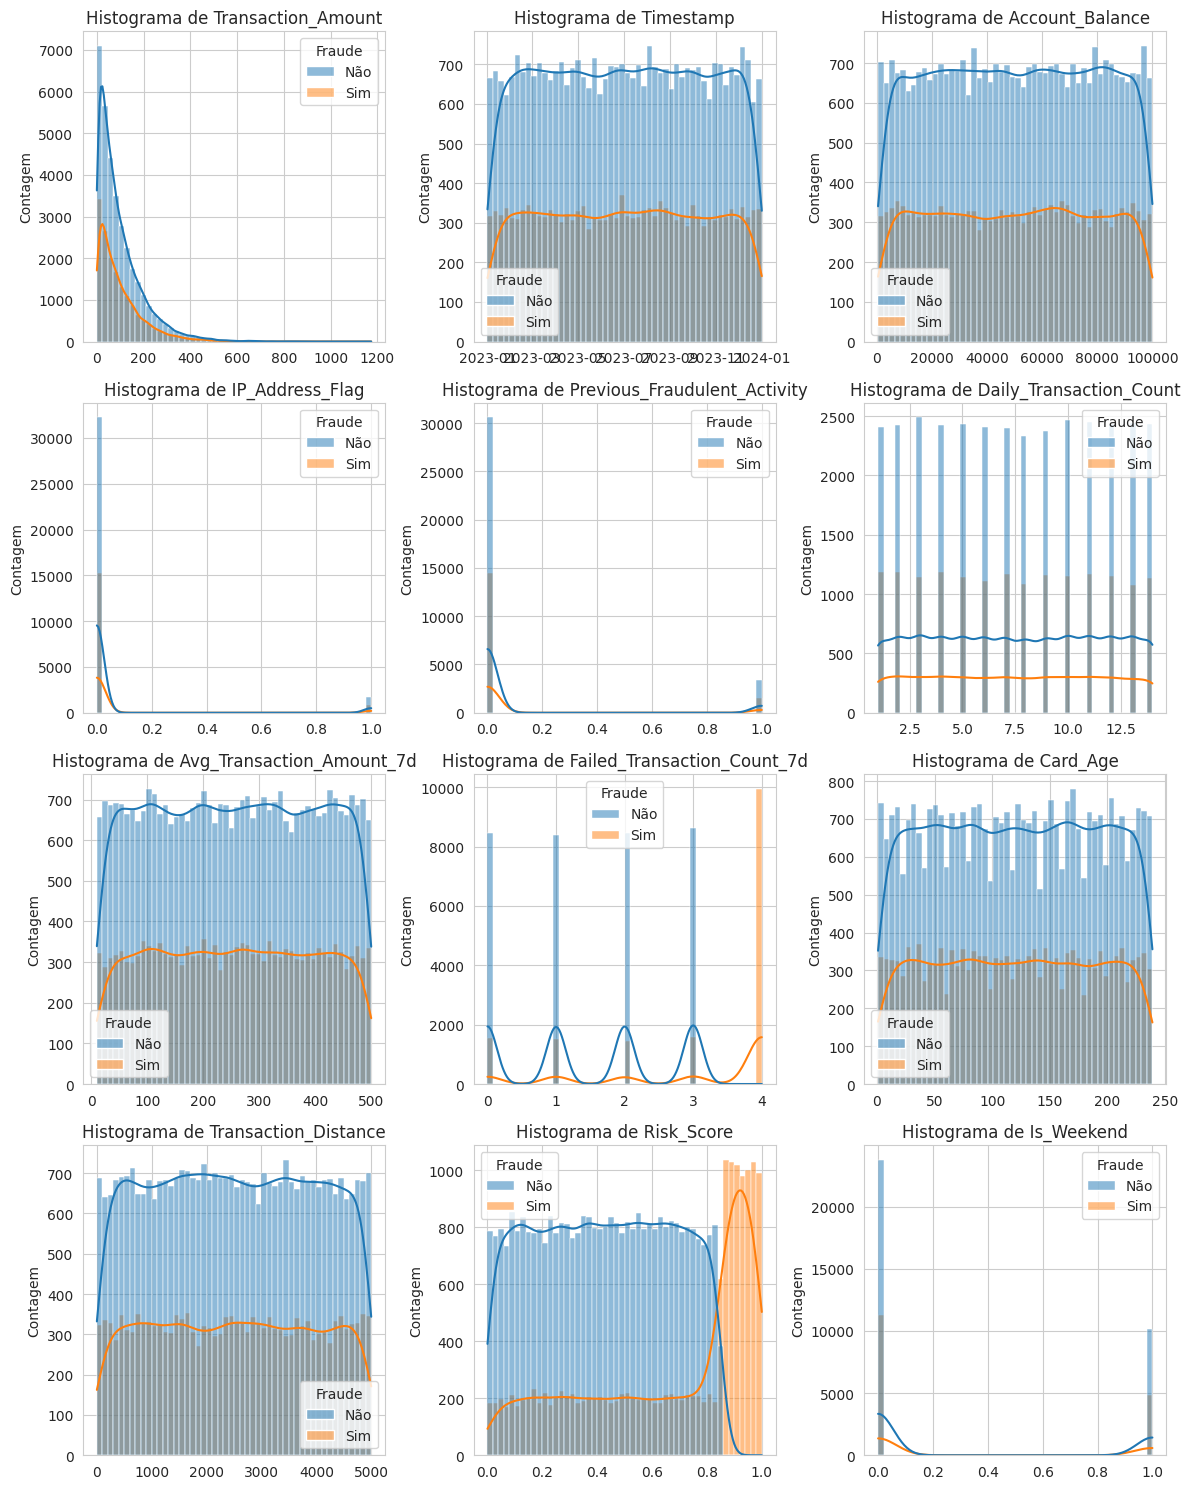

In [ ]:
# Criando a matriz de histogramas
fig, axes = plt.subplots(4, 3, figsize=(12, 15))

# Achatando a matriz de eixos
axes = axes.flatten()

# Removendo a coluna Fraud_Label do histograma, pois estamos usando hue
numeric_cols2 = [col for col in numeric_cols if col != 'Fraud_Label']

# Mapeando 0:Nao e 1:Sim e colocando em uma coluna de nome "Fraude"
data['Fraude'] = data['Fraud_Label'].map({0: 'Não', 1: 'Sim'})

# Percorrendo as colunas numéricas
for i, col in enumerate(numeric_cols2):
    sns.histplot(data=data, x=col, bins=50, kde=True, hue='Fraude', ax=axes[i])
    axes[i].set_title(f"Histograma de {col}", fontsize=12)
    axes[i].set_ylabel("Contagem", fontsize=10)
    axes[i].set_xlabel('')

# Removendo os eixos não utilizados
for i in range(len(numeric_cols2), len(axes)):
    fig.delaxes(axes[i])

# Ajustando o layout
plt.tight_layout()

# Plotando o gráfico
plt.show()

* A área com Risk_Score acima de 0.9 é onde a maioria das transações fraudulentas se encontra. (resultado já esperado)
* O Risk_Score baixo (menor que 0.9) é um forte indicador de transação legítima nesta base de dados, enquanto um escore alto (maior que 0.9) é um indicador de transação fraudulenta.

* Alto Valor de *Failed_Transaction_Count_7d*: Uma contagem de 4 transações falhadas nos últimos 7 dias é um forte indicador de que a transação é fraudulenta.

* Baixo Valor de *Failed_Transaction_Count_7d* Uma contagem de 0, 1, 2 ou 3 transações falhadas nos últimos 7 dias é um forte indicador de que a transação é legítima.

# BoxPlot das *Features* Numéricas Não Binárias

* O Boxplot é uma ferramenta estatística projetada para visualizar a distribuição de variáveis numéricas contínuas ou discretas com muitos valores.
* A "distribuição" de dados binários não tem sentido em termos de quartis ou mediana da forma como o boxplot os apresenta.


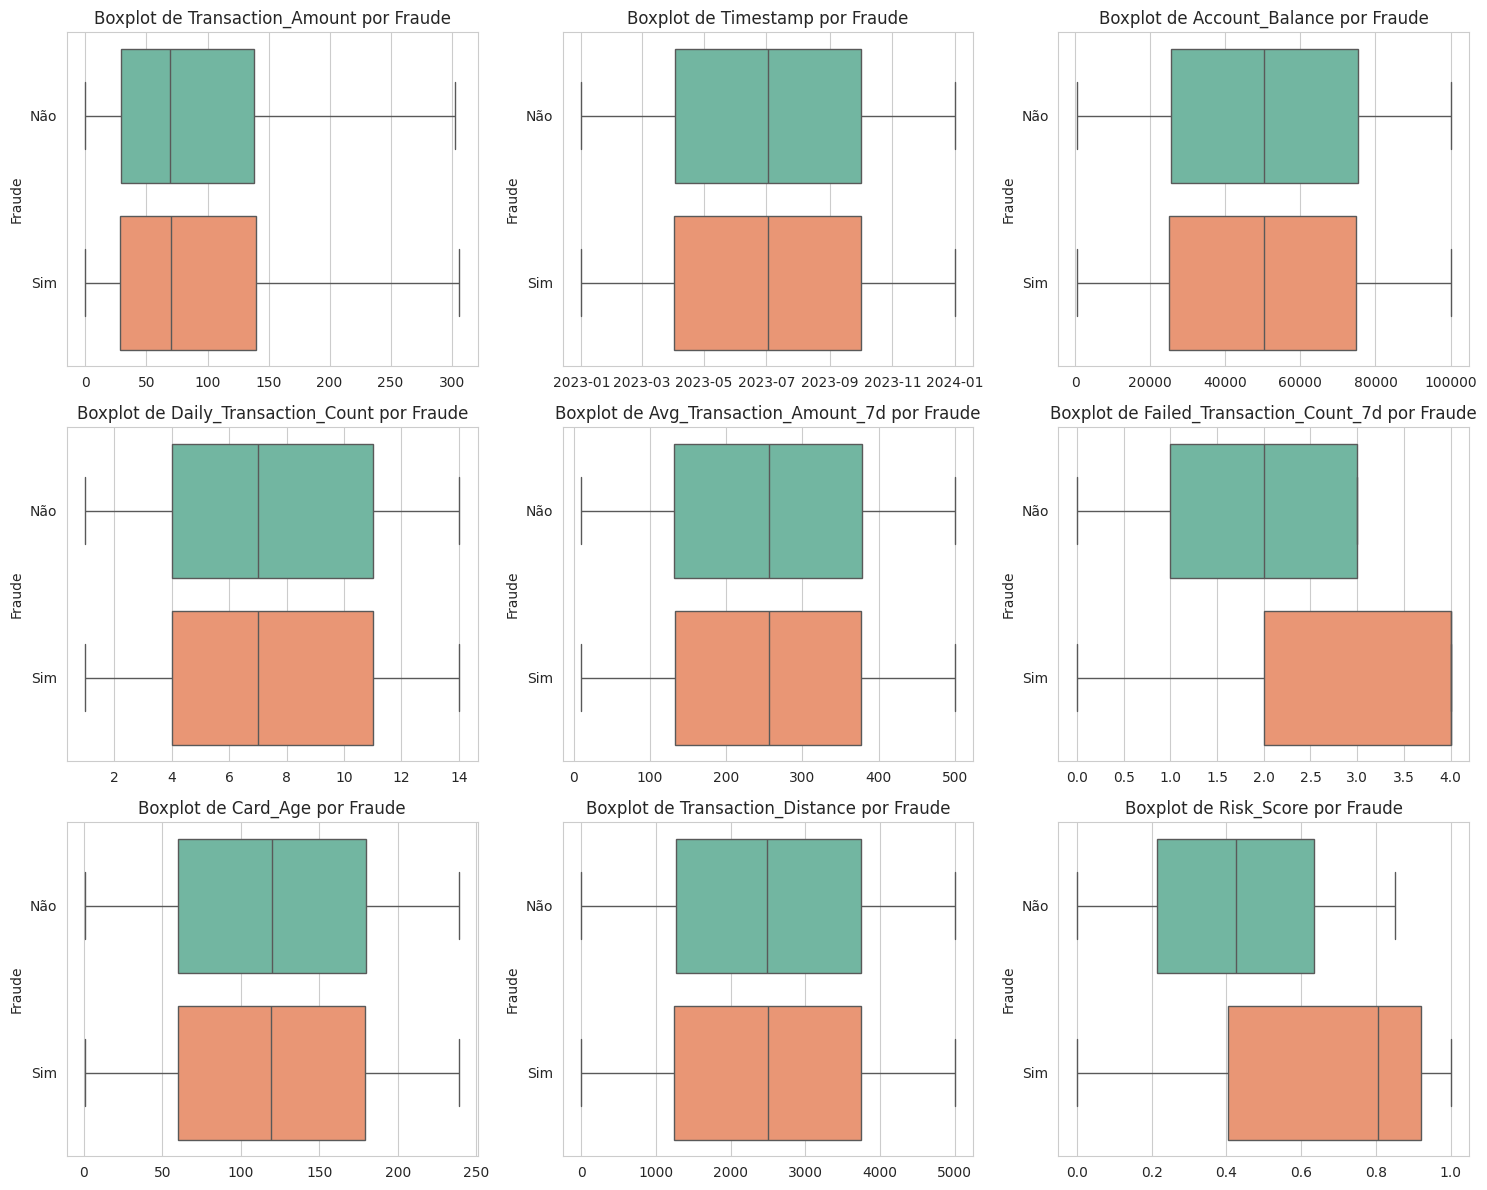

In [ ]:

# Removendo as variaveis binárias da base
non_binary_cols = [
    col for col in numeric_cols
    if len(data[col].unique()) > 2
]

# Criando a figura e os subplots (matriz 3x3)
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Iterando sobre as colunas
for i, col in enumerate(non_binary_cols):
    sns.boxplot( data=data, x=col, y='Fraude', palette="Set2", showfliers=False, ax=axes[i])

    # Definindo os títulos e rótulos
    axes[i].set_title(f"Boxplot de {col} por Fraude", fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel("Fraude", fontsize=10)

# Removendo os graficos vazios
for i in range(len(non_binary_cols), len(axes)):
    fig.delaxes(axes[i])

#Ajustando o layout para evitar sobreposição
plt.tight_layout()

# Exibindo o gráfico
plt.show()


* BoxPlot reforçando a ideia:
** Registros com Risk_Score alto são indicadores de transações fraudulentas.
<br>
** Alto Valor de Failed_Transaction_Count_7d é um forte indicador de que a transação é fraudulenta.


## Gráfico de Barras para a contagem das *Features* Categóricas


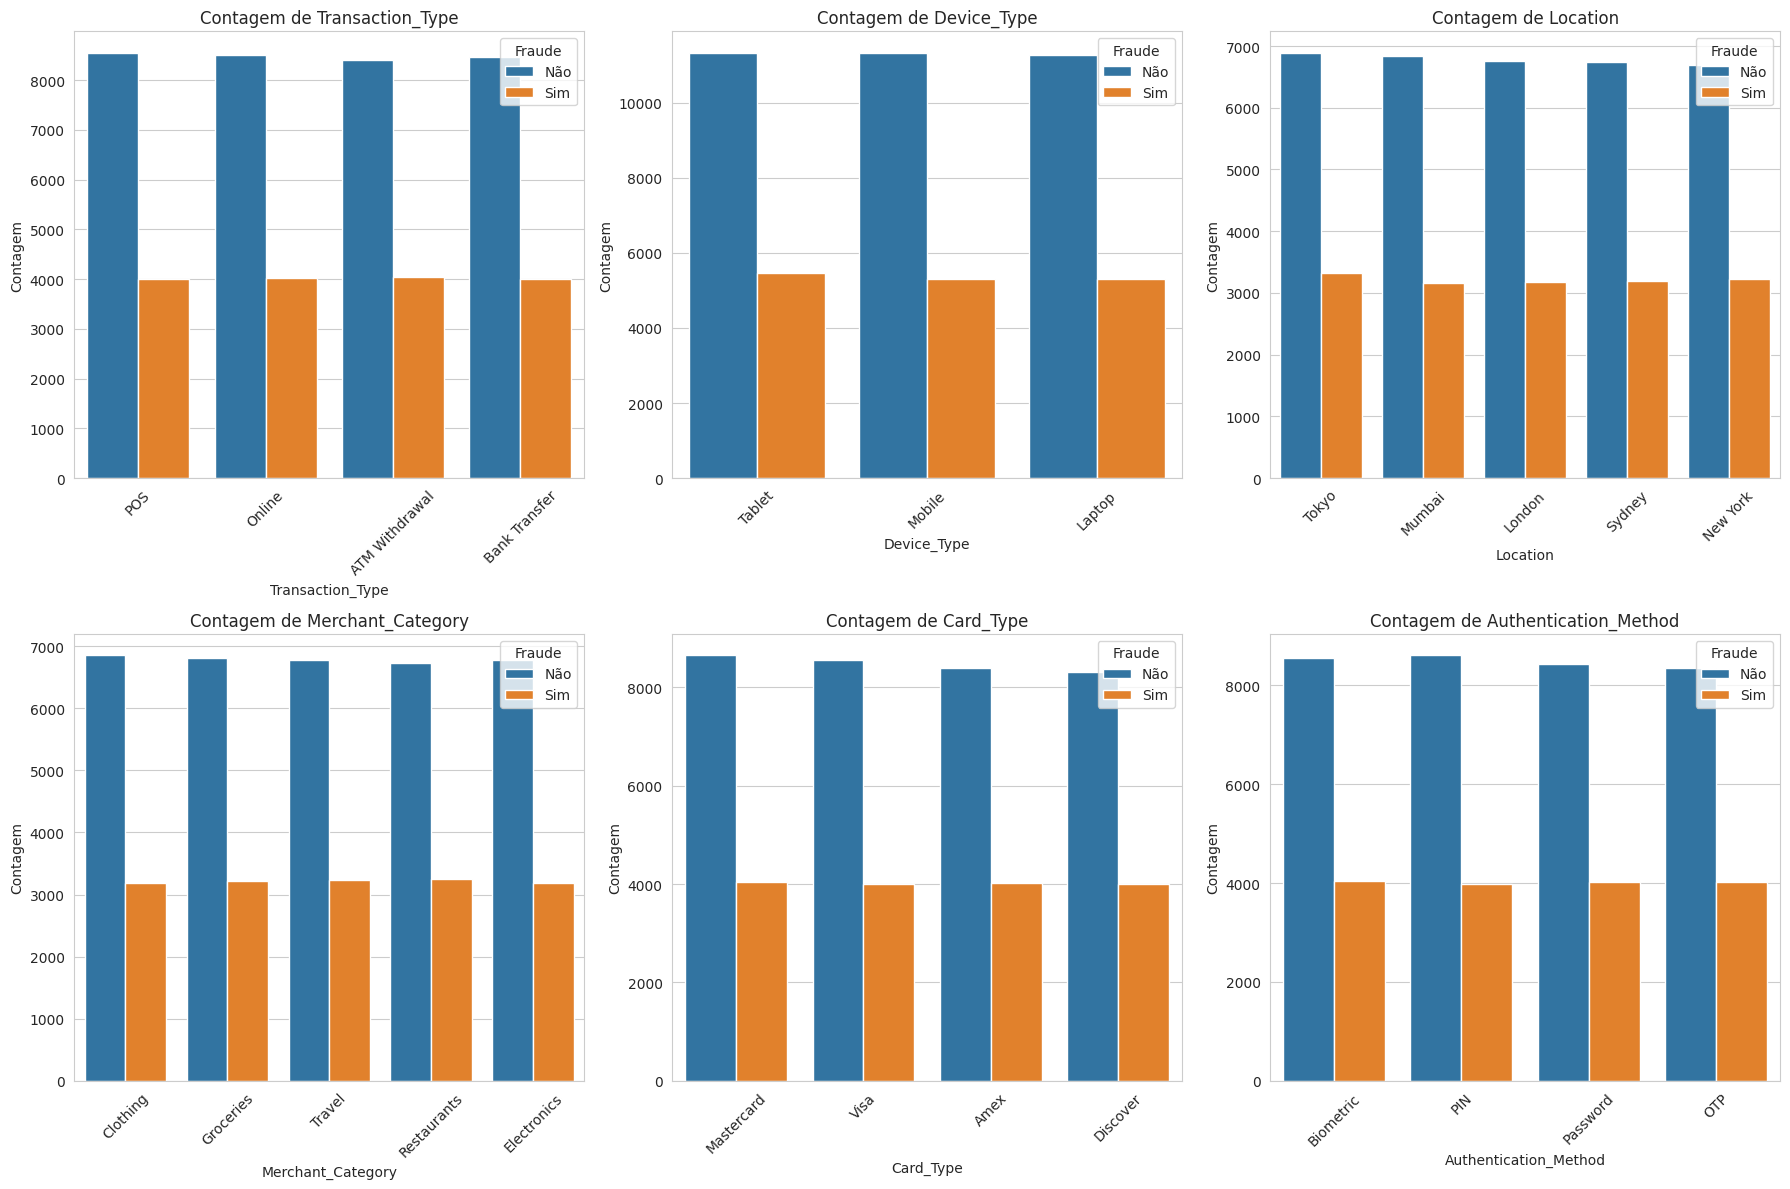

In [ ]:

# Cria a figura e os subplots.
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes = axes.flatten()

# Percorrendo as categóricas
for i, col in enumerate(categorical_cols):
    if i < 12:
        sns.countplot(data=data, x=col, hue='Fraude', order=data[col].value_counts().index, ax=axes[i])

        # Ajustando os títulos e rótulos
        axes[i].set_title(f"Contagem de {col}", fontsize=12)
        axes[i].set_xlabel(col, fontsize=10)
        axes[i].set_ylabel("Contagem", fontsize=10)

        # Rotacionando o eixo X
        axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.show()

* Em uma primeira análise visual, de forma geral as variáveis categóricas não ajudam a diferenciar transações fraudulentas das não fraudulentas. (Pelo menos na visualização das variáveis de forma independente)

# Matriz de Correlação com Mapa de Calor

### Correlação de Pearson: Mede a relação linear entre duas variáveis.

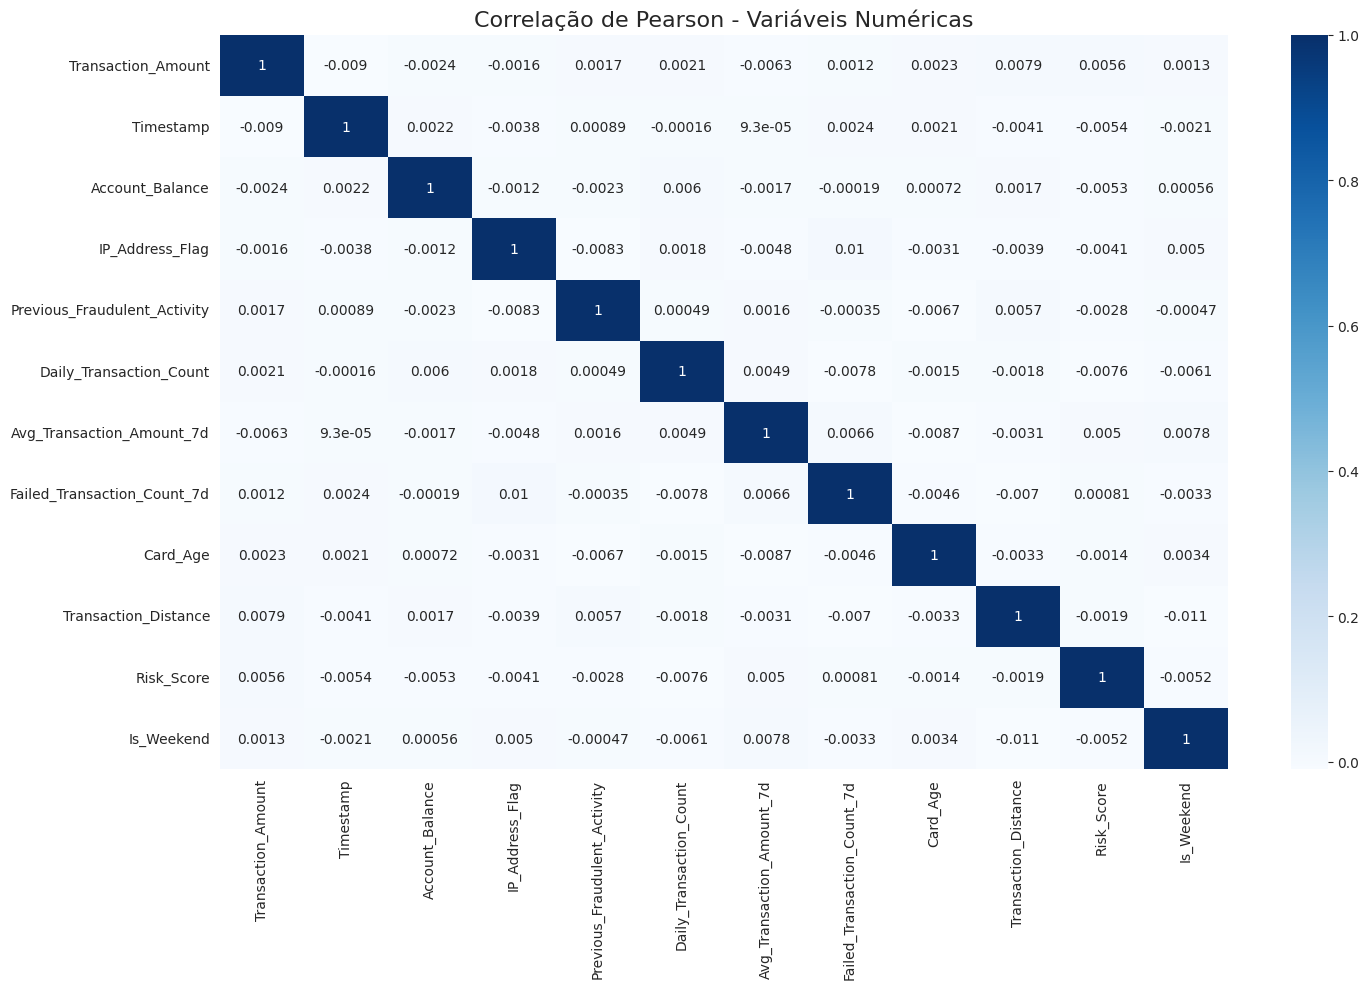

In [ ]:
data_numeric = data[numeric_cols].drop(columns=['Fraud_Label'])

plt.figure(figsize=(15, 10))

sns.heatmap(data_numeric.corr(), annot=True, cmap='Blues')

plt.title("Correlação de Pearson - Variáveis Numéricas", fontsize=16)
plt.tight_layout()
plt.show()

### Correlação de Spearman:

Mede a relação de monotonicidade, que é uma relação geral entre duas variáveis, sem se importar com a forma exata dessa relação.

Funciona com os rankings dos valores, em vez dos próprios valores, tornando-o menos sensível a outliers e a relações não lineares.

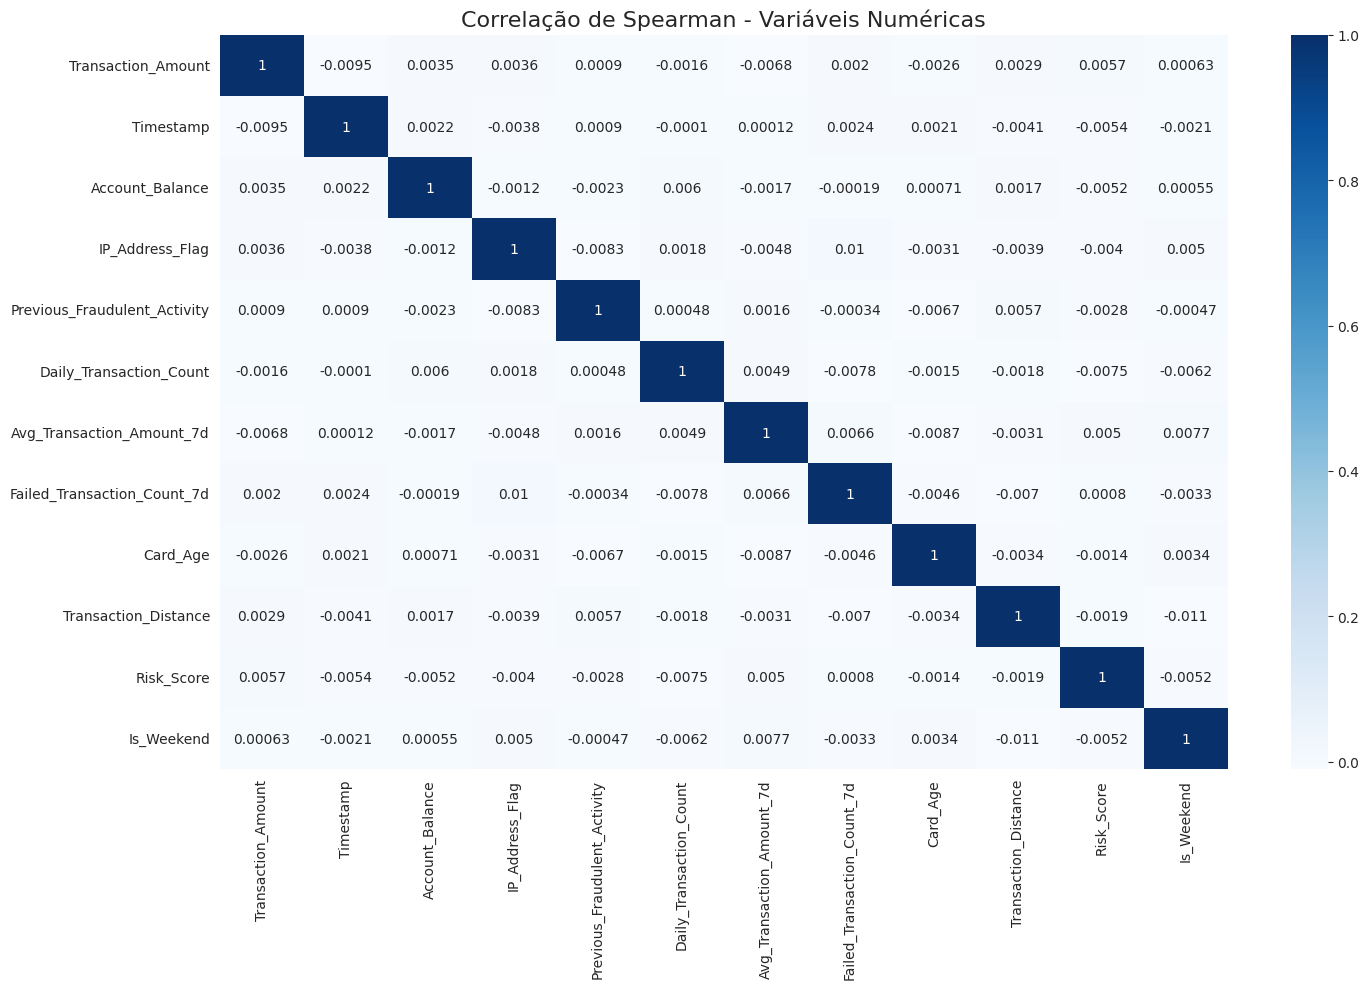

In [ ]:
plt.figure(figsize=(15, 10))

sns.heatmap(data_numeric.corr(method="spearman"), annot=True, cmap='Blues')

plt.title("Correlação de Spearman - Variáveis Numéricas", fontsize=16)
plt.tight_layout()
plt.show()

#Tratamento e Limpeza dos Dados

In [ ]:
#Separando o horario, o dia da semana e o mês do timestamp
data['Hour'] = data['Timestamp'].dt.hour
data['Weekday'] = data['Timestamp'].dt.weekday
data['Month'] = data['Timestamp'].dt.month

data.drop('Timestamp', axis=1, inplace=True)

data.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,...,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label,Fraude,Hour,Weekday,Month
0,TXN_33553,USER_1834,39.79,POS,93213.17,Laptop,Sydney,Travel,0,0,...,65,883.17,Biometric,0.8494,0,0,Não,19,0,8
1,TXN_9427,USER_7875,1.19,Bank Transfer,75725.25,Mobile,New York,Clothing,0,0,...,186,2203.36,Password,0.0959,0,1,Sim,4,2,6
2,TXN_199,USER_2734,28.96,Online,1588.96,Tablet,Mumbai,Restaurants,0,0,...,226,1909.29,Biometric,0.8400,0,1,Sim,15,1,6
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,76807.20,Tablet,New York,Clothing,0,0,...,76,1311.86,OTP,0.7935,0,1,Sim,0,3,12
4,TXN_39489,USER_2014,31.28,POS,92354.66,Mobile,Mumbai,Electronics,0,1,...,140,966.98,Password,0.3819,1,1,Sim,23,5,11


É fundamental separar a coluna de timestamp em componentes como hora, dia da semana e mês. Essa técnica de "engenharia de features" captura os padrões periódicos. A separação permite que o modelo identifique e aprenda com a periodicidade dos eventos:<br>
**Hour:** O modelo pode aprender que a atividade fraudulenta é menor nas horas da tarde e maior nas madrugadas, por exemplo.<br>
**Weekday:** O modelo pode identificar que as fraudes são maiores em algum dia específico da semana.<br>
**Month:** O modelo pode aprender com a sazonalidade, como um aumento nas fraudes podem ocorrer em determinado período, como pagamento de salários no quinto dia útil.

In [ ]:
# após o tratamanto, separar novamente as colunas numéricas das categóricas
numeric_cols = data.select_dtypes(include=["int64", "float64", "datetime64[ns]", "int32"]).columns.drop('Fraud_Label')
categorical_cols = data.select_dtypes(include=["object"]).columns.drop(['Fraude', 'Transaction_ID', 'User_ID'])

print ("Colunas numéricas:", numeric_cols)
print ("Colunas categóricas:", categorical_cols)

Colunas numéricas: Index(['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
       'Transaction_Distance', 'Risk_Score', 'Is_Weekend', 'Hour', 'Weekday',
       'Month'],
      dtype='object')
Colunas categóricas: Index(['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
       'Card_Type', 'Authentication_Method'],
      dtype='object')


In [ ]:
#separando em X e y

# Retirando do X os IDs, o target(Fraude e Fraud_Label)
X = data.drop(columns=['Fraud_Label', 'Fraude', 'Transaction_ID', 'User_ID'])
y = data['Fraud_Label']


# Retirando também o Risk_Score, pois acreditamos que essa coluna deva ser usado em problemas de Regressão nessa Base.
# Rodando com o risck_score o XGBoost apresentou 100% na F1-score. (muito raro modelo com 100% de acerto)
X = X.drop(columns=['Risk_Score'])
numeric_cols = numeric_cols.drop('Risk_Score')

print(X.columns)


Index(['Transaction_Amount', 'Transaction_Type', 'Account_Balance',
       'Device_Type', 'Location', 'Merchant_Category', 'IP_Address_Flag',
       'Previous_Fraudulent_Activity', 'Daily_Transaction_Count',
       'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Type',
       'Card_Age', 'Transaction_Distance', 'Authentication_Method',
       'Is_Weekend', 'Hour', 'Weekday', 'Month'],
      dtype='object')


## **Aplicar o MinMaxScaler nas variáveis numéricas:**
MinMaxScaler = Transforma as features para que fique em um intervalo é entre 0 e 1.<br>
* Benefícios do MinMaxScaler: <br>
** Evita que uma variável domine as outras.
** Beneficia modelos que calculam distâncias. (ex:KNN)
** Melhora a convergência de algoritmos que usam descida de gradiente (ex: Regressão Logística)
<br>
OBS: O XGBoost é baseado em árvore de decisão, por isso não é beneficiado pelo MinMaxScaler.
<br>
* Desafios do MinMaxScaler: <br>
** Muito sensível a outliers. A fórmula do MinMax Scaling depende diretamente dos valores mínimo e máximo da sua variável. Se houver um ou mais outliers, eles podem distorcer completamente a escala.
* Alternativas ao MinMaxScaler: <br>
** Standard Scaler: Modelo que usa média e desvio padrão na mudança de escala, tornando-o menos sensível a outliers, porém parte do pressuposto que as features possuam o comportamento de uma distribuição normal.
** RobustScaler: Técnica de pré-processamento de dados projetada para lidar com outliers de forma mais eficaz do que outros métodos de normalização.


## **Aplicar o OneHotEncoding nas variáveis categóricas:**
OneHotEncoding = Cria novas colunas para cada categoria única presente na variável original. As novas colunas são binárias, ou seja, só podem ter os valores 0 ou 1. <br>


Exemplo:

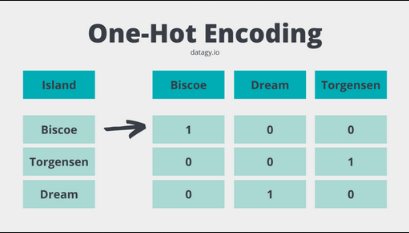


* Benefícios do OneHotEncoding: <br>
** Permite o uso de variáveis categóricas em modelos matemáticos (ex: KNN, Regressão Logística).
** Evita que os modelos utilizem ordem para as variáveis categóricas.
** Melhora o desempenho de modelos baseados em distância, pois todas as categóricas ficarão na mesma escala binária.
<br>
OBS: O XGBoost é baseado em árvore de decisão e dessa forma poderia trabalhar com dados categóricos.
<br>
* Desafios do OneHotEncoding: <br>
** Aumento da Dimensionalidade: O One-Hot Encoding pode agravar o problema de modelos com muitas dimensões, especialmente quando a variável categórica que você está codificando tem um grande número de categorias únicas. Isso gera aumento da complexidade do modelo, riscos de overfitting, matrizes esparsas.
<br>
* Alternativas ao OneHotEncoding: <br>
** Codificação por Frequência (Frequency Encoding): Substitui cada categoria pela sua frequência de ocorrência.
** Codificação por Alvo (Target Encoding): Substitui cada categoria pela média do valor da variável alvo para aquela categoria.


In [ ]:
#separando o X_numerico e o X_categorico
X_num = X[numeric_cols]
X_cat = X[categorical_cols]

#aplicando o MinMaxScaler nas numéricas
scaler = MinMaxScaler()
X_num2 = scaler.fit_transform(X_num)

#aplicando o OneHotEncoder nas categóricas
# gerando uma matriz densa de saída (não esparsa)
# ignorando se novas classes forem encontradas pelo modelo
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat2 = encoder.fit_transform(X_cat)

#concatenando as listas
X_prepro = np.concatenate([X_num2, X_cat2], axis=1)
X_prepro_colums = X_num.columns.to_list() + encoder.get_feature_names_out(X_cat.columns).tolist()

#criando um dataframe final
X_prepro_df = pd.DataFrame(X_prepro, columns=X_prepro_colums)

# X_prepro_df.info()

# Tratamento das Classes Desbalanceadas.
* Fenômeno comum em datasets de fraude.


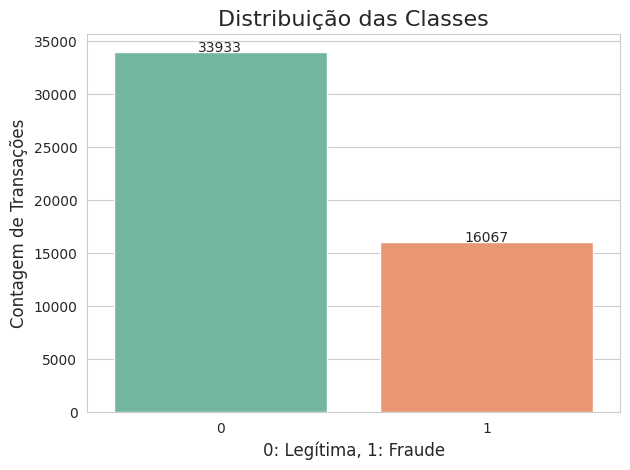

In [ ]:
# Criando gráfico de contagem das classes
ax = sns.countplot(x=y, palette='Set2')

# apenas colocando a contagem dos registros em cima das barras
for p in ax.patches:
    height = int(p.get_height())
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 1,
        s=f'{height}',
        ha='center'
    )
# colocando labels
plt.title("Distribuição das Classes", fontsize=16)
plt.xlabel("0: Legítima, 1: Fraude", fontsize=12)
plt.ylabel("Contagem de Transações", fontsize=12)

plt.tight_layout()
plt.show()

# Aplicar o SMOTE para balanceamento das classes.

O SMOTE gera novos pontos de dados que sejam semelhantes, mas não idênticos, aos exemplos já existentes da classe minoritária.
* Benefícios do SMOTE: <br>
** O SMOTE resolve o problema do desbalanceamento de classes, criando novos dados sintéticos para a classe minoritária. Em vez de simplesmente copiar os dados existentes, o SMOTE seleciona exemplos da classe minoritária e, a partir deles, cria novos exemplos semelhantes, mas ligeiramente diferentes, usando interpolação. Isso equilibra o conjunto de dados e permite que o modelo aprenda melhor as características da classe minoritária.

* Desafios do SMOTE:<br>
** Ruído: Os novos dados sintéticos criados podem estar na região de outra classe, confundindo o modelo.
** Overlapping de Classes: O SMOTE não diferencia entre pontos de dados úteis e aqueles que já estão em regiões de sobreposição. Ele simplesmente cria novos pontos, o que pode piorar a sobreposição e dificultar para o modelo encontrar um limite de decisão claro.

* Alternativas ao SMOTE: <br>
** Random Oversampling: Consiste em copiar aleatoriamente exemplos da classe minoritária até que o conjunto de dados esteja balanceado.
** ADASYN: Variante do SMOTE, ele busca criar mais dados sintéticos para os exemplos da classe minoritária que são mais difíceis de classificar.

<br><br>
**IMPORTANTE:** O SMOTE é aplicado apenas no conjunto de treino, pois ele gera dados artificiais

In [ ]:
# Separando os dados em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X_prepro, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
# Aplicando o SMOTE no treino (nunca no teste)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


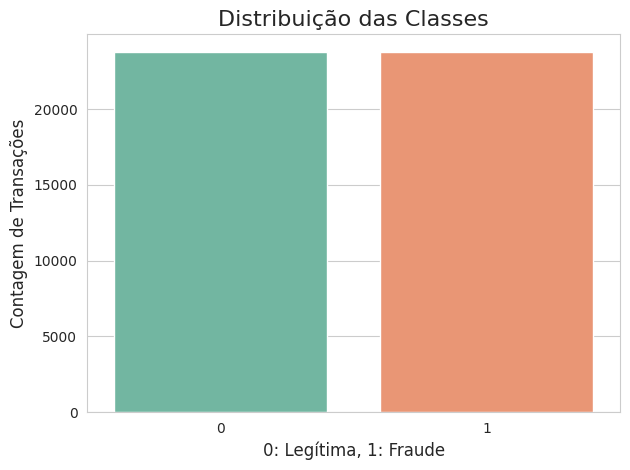

In [ ]:
#gerando o grafico da nova distribuição do Y de treino
ax = sns.countplot(x=y_train, palette='Set2')

# Adiciona título e rótulos
plt.title("Distribuição das Classes", fontsize=16)
plt.xlabel("0: Legítima, 1: Fraude", fontsize=12)
plt.ylabel("Contagem de Transações", fontsize=12)

plt.tight_layout()
plt.show()

#Implementação das Métricas de Avaliação

In [ ]:
def imprimeMetricas(y_real, y_pred, y_proba=None):

    f1score = f1_score(y_real, y_pred)
    classif = classification_report(y_real, y_pred, digits=4)

    if y_proba is not None:
      rocauc = roc_auc_score(y_test, y_proba)
      print(f"AUC-ROC: {rocauc:.4f}\n")

    print(f"F1 Score: {f1score:.4f}\n")
    print(f"Classification Report:\n {classif}")

def imprimeMatrizConfusao(y_test, y_pred, norm=None):

    # Calculando a matriz de confusão
    cm = confusion_matrix(y_test, y_pred, normalize=norm)

    # Gerando a figura pro grafico
    fig, ax = plt.subplots(figsize=(6, 5))

    # Ajustando o título e o formato de exibição dos dados
    if norm is not None:
      cm = cm * 100
      fmt = ".2f"
      title = "Matriz de Confusão Normalizada (%)"
    else:
       title = "Matriz de Confusão"
       fmt = "d"

    # Montando o grafico da matriz
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sem Fraude', 'Com Fraude'])
    disp.plot(ax=ax, values_format=fmt, cmap='Blues', colorbar=True)
    ax.set_title(title, fontsize=13, fontweight='bold')

    # Labels dos eixos
    ax.set_xlabel("Previsão", fontsize=12)
    ax.set_ylabel("Real", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Remove o grid ma matriz
    ax.grid(False)

    plt.tight_layout()
    plt.show()

AUC-ROC: 0.8048

F1 Score: 0.6323

Classification Report:
               precision    recall  f1-score   support

           0     0.8471    0.7370    0.7883     10180
           1     0.5642    0.7191    0.6323      4820

    accuracy                         0.7313     15000
   macro avg     0.7057    0.7281    0.7103     15000
weighted avg     0.7562    0.7313    0.7381     15000



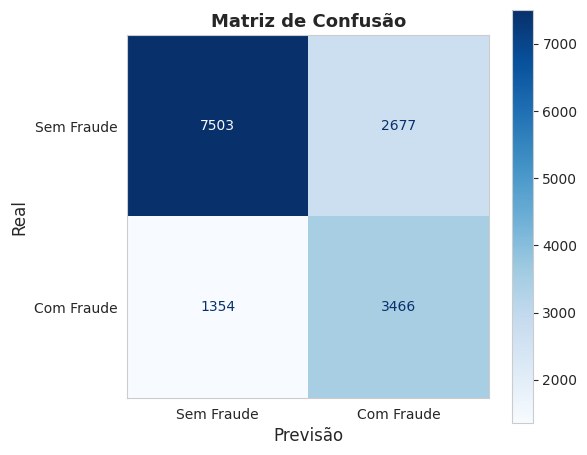

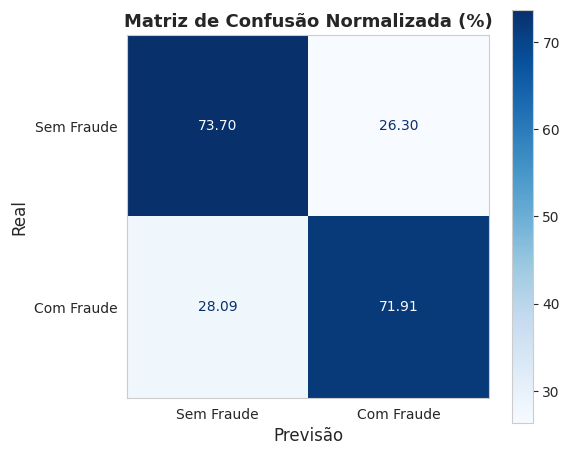

AUC-ROC: 0.8068

F1 Score: 0.7606

Classification Report:
               precision    recall  f1-score   support

           0     0.8467    0.9957    0.9152     10180
           1     0.9855    0.6193    0.7606      4820

    accuracy                         0.8747     15000
   macro avg     0.9161    0.8075    0.8379     15000
weighted avg     0.8913    0.8747    0.8655     15000



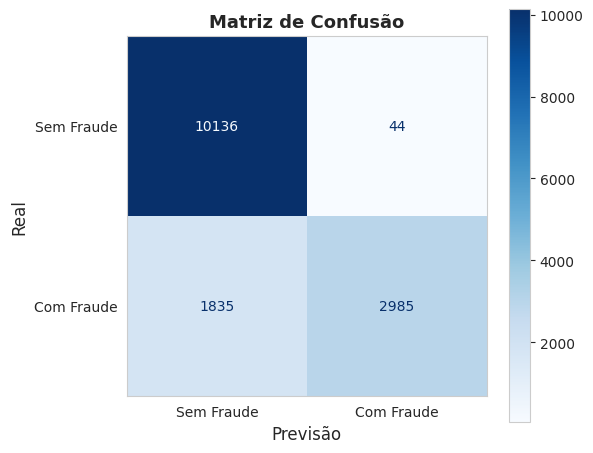

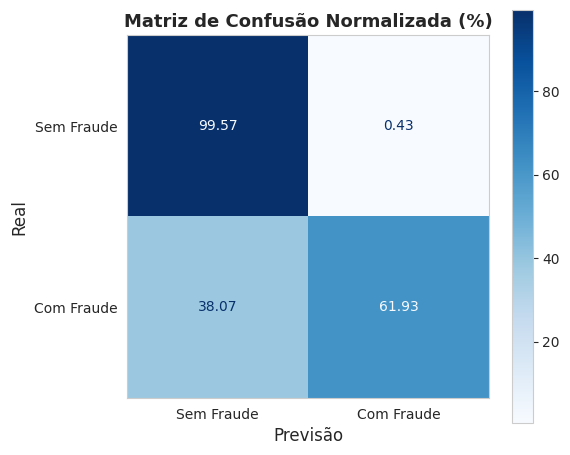

In [ ]:
#rodando uma RL e xgboost sem hiperparametros, apenas para testar a visualização dos resultados.
# IMPORTANTE: Deletar essa celula depois, pois usaremos hiperparametros conforme pedido na especificação

from sklearn.linear_model import LogisticRegression
# regressao logistica
model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_proba = model.predict_proba(X_test)[:, 1]

imprimeMetricas(y_test, y_pred, y_proba)

imprimeMatrizConfusao(y_test, y_pred)

imprimeMatrizConfusao(y_test, y_pred, norm='true')


import xgboost as xgb
model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    eval_metric = 'logloss',
)

# Treinar o modelo XGBoost
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

imprimeMetricas(y_test, y_pred, y_proba)

imprimeMatrizConfusao(y_test, y_pred)

imprimeMatrizConfusao(y_test, y_pred, norm='true')




#Modelo 1 - Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import os

SEED = 42
# validação cruzada estratificada, mantendo a proporção de fraude em cada fold, com splits estáveis e comparáveis entre rodadas (SEED).

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

'''
Por que esses parâmetros no LogisticRegression

solver="saga": é o único solver do sklearn que suporta L1, L2 e elasticnet e lida bem com matrizes esparsas (que surgem após One-Hot Encoding). Também escala melhor para bases grandes.

max_iter=5000: dá folga para o otimizador convergir, especialmente quando usamos L1/elasticnet.

class_weight="balanced": reequilibra a perda ponderando a classe rara (fraude). Útil em datasets desbalanceados. Como já aplicamos o SMOTE no treino, não seria necessário. Podemos até testar SEM
n_jobs=-1: usa todos os núcleos disponíveis quando aplicável (no LR isso ajuda principalmente em cenários multiclasses OvR; em binário o ganho é pequeno, mas não atrapalha).
'''

rl = LogisticRegression(
    solver="saga",          # permite L1/L2/elasticnet
    max_iter=5000,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

param_dist_rl = {
    "penalty": ["l1", "l2", "elasticnet"],
    "C": np.logspace(-3, 2, 20),         # gera 20 valores, entre 10^-3 (0,001) e 10^2 (100). Segundo a documentação, C deve ser um valor positivo:
                                        #Inverso da força de regularização; deve ser um ponto flutuante positivo. Assim como em máquinas de vetores de suporte,
                                        #valores menores especificam uma regularização mais forte.

    "l1_ratio": [0.0, 0.25, 0.5, 0.75]   # usado somente se penalty='elasticnet'
}

search_rl = RandomizedSearchCV(
    estimator=rl,
    param_distributions=param_dist_rl,
    n_iter=40,  # amostra de 40 combinações aleatórias
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

search_rl.fit(X_train, y_train)
rl_best = search_rl.best_estimator_
print("Melhores params (LogReg):", search_rl.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores params (LogReg): {'penalty': 'l1', 'l1_ratio': 0.0, 'C': np.float64(0.003359818286283781)}


AUC-ROC: 0.8050

F1 Score: 0.6323

Classification Report:
               precision    recall  f1-score   support

           0     0.8471    0.7370    0.7883     10180
           1     0.5642    0.7191    0.6323      4820

    accuracy                         0.7313     15000
   macro avg     0.7057    0.7281    0.7103     15000
weighted avg     0.7562    0.7313    0.7381     15000



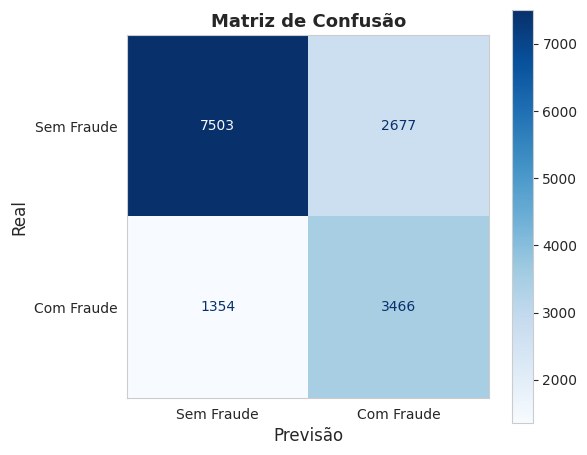

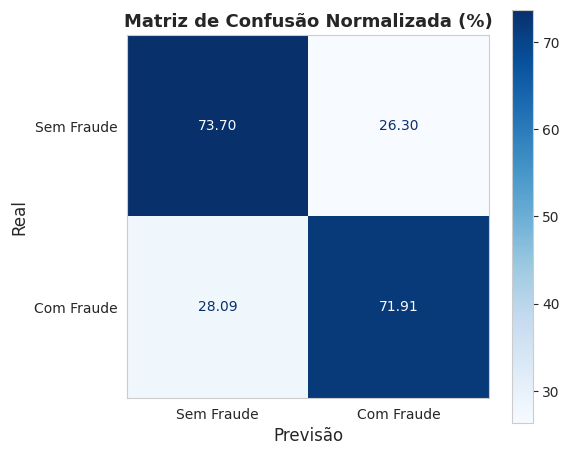

In [ ]:
# Avaliação
y_pred_rl  = rl_best.predict(X_test)
y_proba_rl = rl_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_rl, y_proba_rl)
imprimeMatrizConfusao(y_test, y_pred_rl)
imprimeMatrizConfusao(y_test, y_pred_rl, norm='true')

#Modelo 2 - KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

param_dist_knn = {
    "n_neighbors": list(range(3, 61, 2)),   # ímpares geralmente funcionam bem, evitam empates em problemas binários,
                                            #limite superior de 59, evita um k muito alto que dilui a decisão,
                                            # e começa no 3, porque k=1 é muito sensível a ruídos
    "weights": ["uniform", "distance"],
    "p": [1, 2],                             # 1=Manhattan, 2=Euclidiana
    "leaf_size": [15, 30, 45, 60]           # testando com valores padrões, onde pode ser que ganhe tempo de processamento sem perder qualidade
}

search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_dist_knn,
    n_iter=40,  #número de combinações testadas. não cobre todas como no GridSearch, mas suficiente para cobrir bem o espaço
    scoring="roc_auc",
    cv=cv,  #StratifiedKfold
    n_jobs=-1,
    random_state=SEED,
    verbose=1
)

search_knn.fit(X_train, y_train)
knn_best = search_knn.best_estimator_
print("Melhores params (KNN):", search_knn.best_params_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits
Melhores params (KNN): {'weights': 'distance', 'p': 1, 'n_neighbors': 13, 'leaf_size': 45}


AUC-ROC: 0.6894

F1 Score: 0.5295

Classification Report:
               precision    recall  f1-score   support

           0     0.7823    0.6987    0.7381     10180
           1     0.4808    0.5892    0.5295      4820

    accuracy                         0.6635     15000
   macro avg     0.6315    0.6440    0.6338     15000
weighted avg     0.6854    0.6635    0.6711     15000



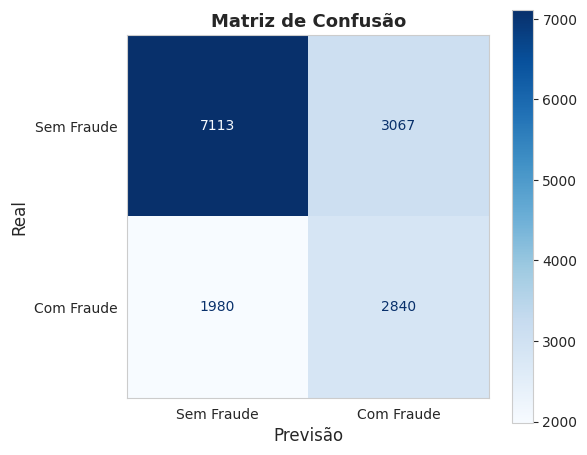

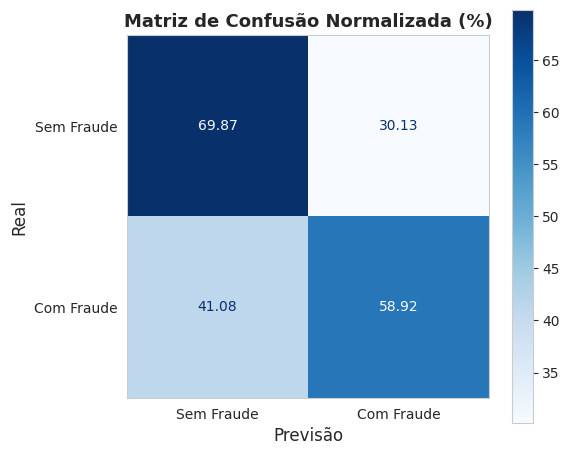

In [ ]:
# Avaliação
y_pred_knn  = knn_best.predict(X_test)
y_proba_knn = knn_best.predict_proba(X_test)[:,1]
imprimeMetricas(y_test, y_pred_knn, y_proba_knn)
imprimeMatrizConfusao(y_test, y_pred_knn)
imprimeMatrizConfusao(y_test, y_pred_knn, norm='true')

# Modelo 3 - XGBoost

### Porque utilizar o RandomSearchCV?

Porque possui hiperparâmetros contínuos ou grandes faixas.
Ao contrário do GridSearch, por exemplo, que exige testar todas as combinações, o RandomSearchCV, em modelos como Regressão Logística ou o XGBoost, permite amostrar valores dessas faixas, cobrindo regiões muito maiores sem precisar testar tudo.
Para um dataset desse tamanho, é o melhor custo-benefício em tempo de execução. É mais rápido quando limita-se o n_iter.

# Qual a *Feature Importance* do Melhor Modelo?

# Considerações Finais
* Meu modelo resolve adequadamente o problema proposto?
* Meu modelo pode ser colocado em produção?